In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import time
from pythonosc import udp_client

In [2]:
# !pip install python-osc

## Weather dataset

In [3]:
fpath = 'weatherData.csv'
df = pd.read_csv(fpath)

In [4]:
def remove_duplicates(df, column_date):
    df = df.drop_duplicates(subset=column_date)
    return df

def get_date_hour(df, column_date):
    df['Date'] = df[column_date].dt.date
    df['Hour'] = df[column_date].dt.hour
    return df

In [5]:
df['Formatted Date'] = pd.to_datetime(df['Formatted Date'],utc=True)
df.sort_values(by='Formatted Date', inplace=True)
df = get_date_hour(df, 'Formatted Date')

columns =  df.columns.tolist()
df = remove_duplicates(df, columns[0])

In [6]:
df.head()

Formatted Date        Summary Precip Type  Temperature (C)  \
2880 2005-12-31 23:00:00+00:00  Partly Cloudy        rain         0.577778   
2881 2006-01-01 00:00:00+00:00  Mostly Cloudy        rain         1.161111   
2882 2006-01-01 01:00:00+00:00  Mostly Cloudy        rain         1.666667   
2883 2006-01-01 02:00:00+00:00       Overcast        rain         1.711111   
2884 2006-01-01 03:00:00+00:00  Mostly Cloudy        rain         1.183333   

      Apparent Temperature (C)  Humidity  Wind Speed (km/h)  \
2880                 -4.050000      0.89            17.1143   
2881                 -3.238889      0.85            16.6152   
2882                 -3.155556      0.82            20.2538   
2883                 -2.194444      0.82            14.4900   
2884                 -2.744444      0.86            13.9426   

      Wind Bearing (degrees)  Visibility (km)  Loud Cover  \
2880                   140.0           9.9820         0.0   
2881                   139.0           9.9015         0.0   
2882                   140.0           9.9015         0.0   
2883                   140.0           9.9015         0.0   
2884                   134.0           9.9015         0.0   

      Pressure (millibars)                      Daily Summary        Date  \
2880               1016.66  Mostly cloudy throughout the day.  2005-12-31   
2881               1016.15  Mostly cloudy throughout the day.  2006-01-01   
2882               1015.87  Mostly cloudy throughout the day.  2006-01-01   
2883               1015.56  Mostly cloudy throughout the day.  2006-01-01   
2884               1014.98  Mostly cloudy throughout the day.  2006-01-01   

      Hour  
2880    23  
2881     0  
2882     1  
2883     2  
2884     3

In [7]:
columns

['Formatted Date',
 'Summary',
 'Precip Type',
 'Temperature (C)',
 'Apparent Temperature (C)',
 'Humidity',
 'Wind Speed (km/h)',
 'Wind Bearing (degrees)',
 'Visibility (km)',
 'Loud Cover',
 'Pressure (millibars)',
 'Daily Summary',
 'Date',
 'Hour']

In [8]:
# Retrieve a column from df as an array
def get_column(df, column):
    return df[column].values

# Write a function to plot any column in the dataframe, with numeric values, against the date column
def plot_column(df, column_date, column):
    print (column)
    df.sort_values(by=column_date, inplace=True)
    plt.figure(figsize = (20, 8))
    x = df[column_date].values
    y = df[column].values
    plt.plot(x, y)
    plt.title(str(column))
    plt.show()

In [9]:
# Write a function returns a new dataframe containing average of column values by date in the original dataframe
def get_average_by_date(df, column):
    df = df.groupby('Date')[column].mean().reset_index()
    return df

In [10]:
df_aggregate_temp = get_average_by_date(df, columns[3])
df_aggregate_humidity = get_average_by_date(df, columns[5])
df_aggregate_ws = get_average_by_date(df, columns[6])
df_aggregate_vis = get_average_by_date(df, columns[8])
df_aggregate_press = get_average_by_date(df, columns[10])

In [11]:
def plot_aggregates(df):
    plt.figure(figsize = (20, 8))
    cols = df.columns.tolist()
    x = df[cols[0]].values
    y = df[cols[1]].values
    plt.plot(x, y)
    plt.title(str(cols[1]))
    plt.show()

Temperature (C)


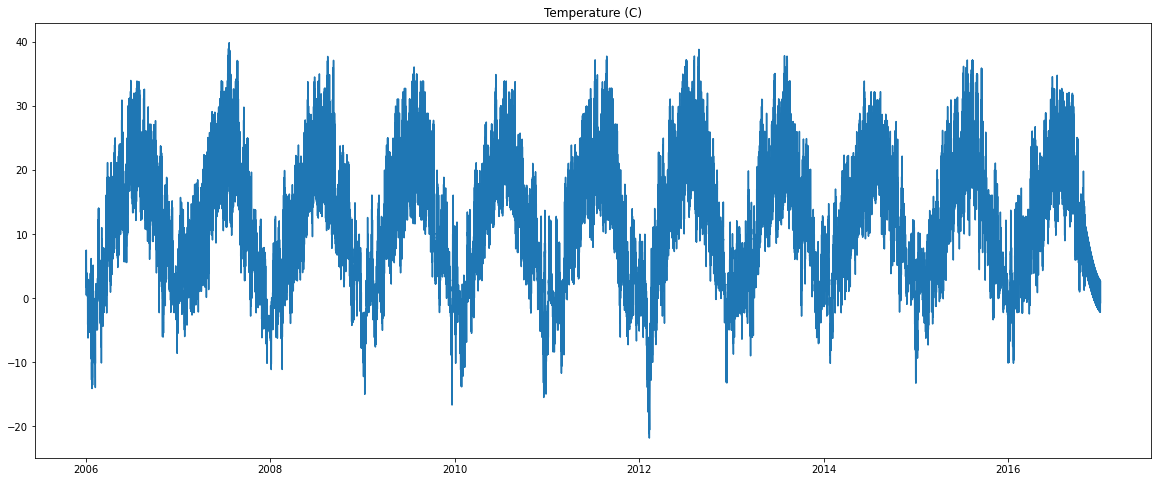

In [12]:
plot_column(df, columns[0], columns[3])

Humidity


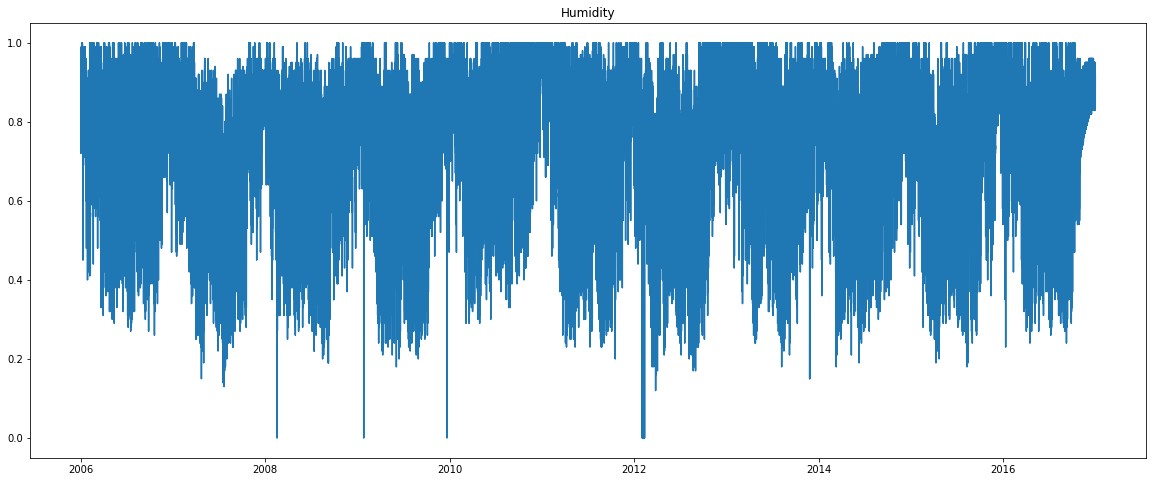

In [13]:
plot_column(df, columns[0], columns[5])

Wind Speed (km/h)


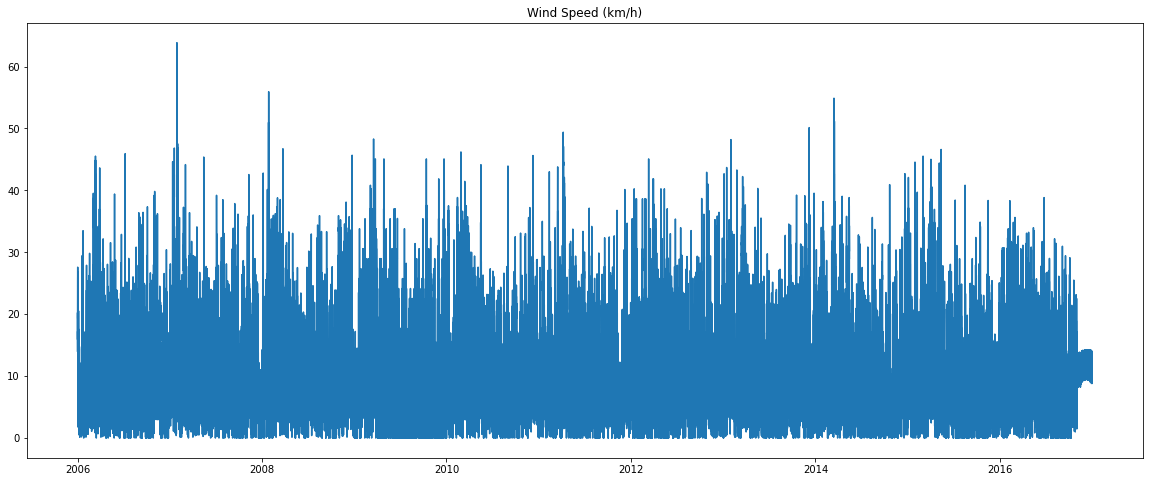

In [14]:
plot_column(df, columns[0], columns[6])

Wind Bearing (degrees)


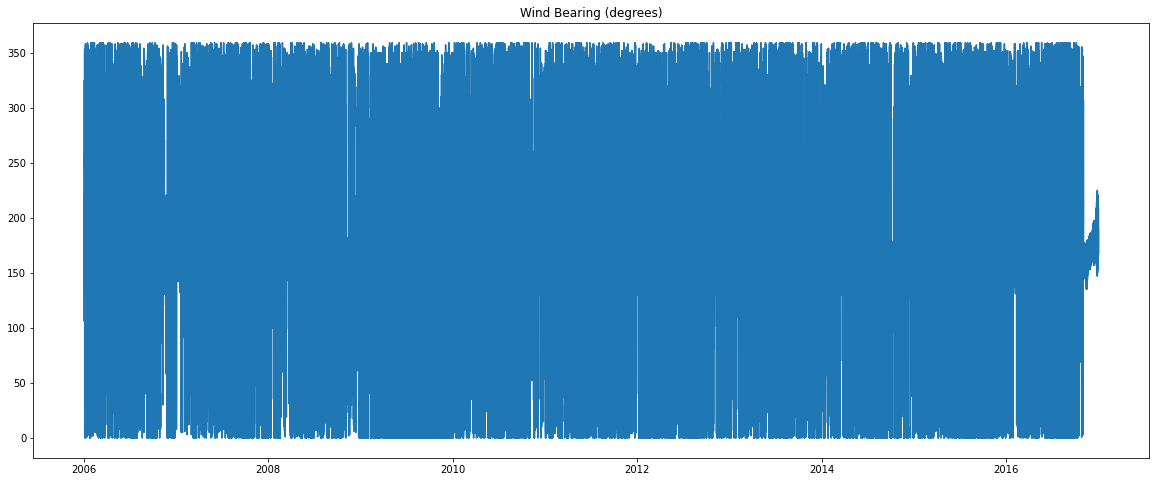

In [15]:
plot_column(df, columns[0], columns[7])

Visibility (km)


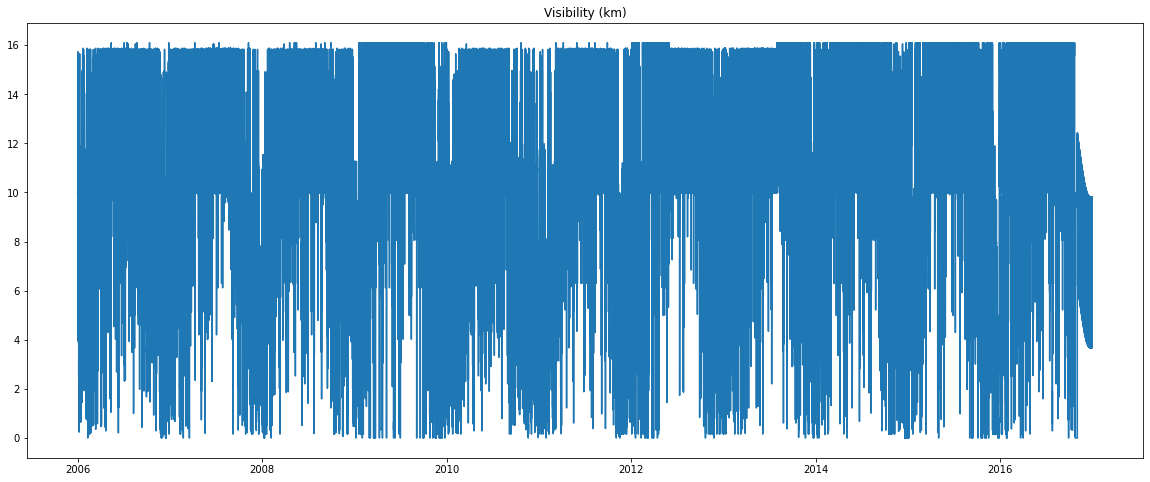

In [16]:
plot_column(df, columns[0], columns[8])

Pressure (millibars)


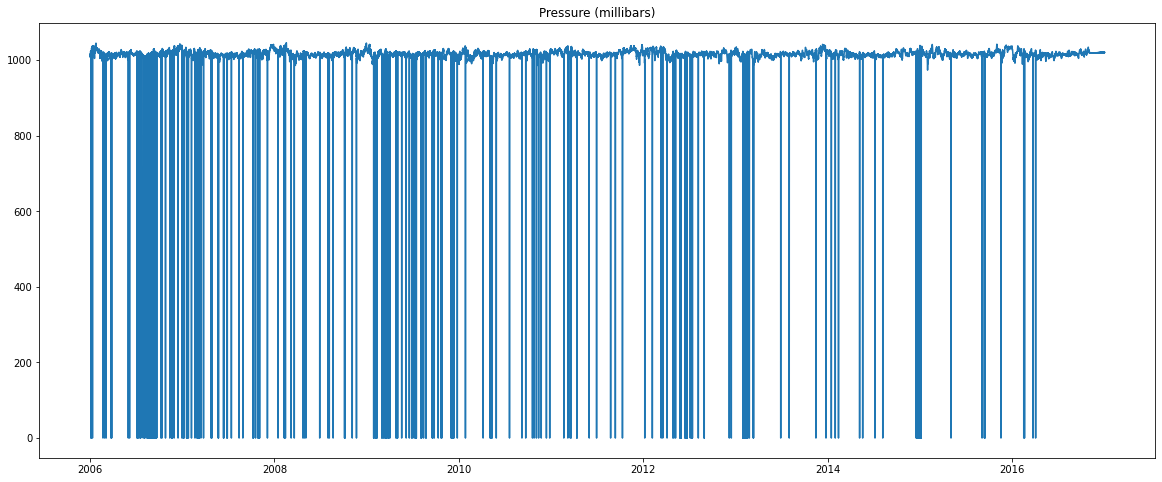

In [17]:
plot_column(df, columns[0], columns[10])

4019


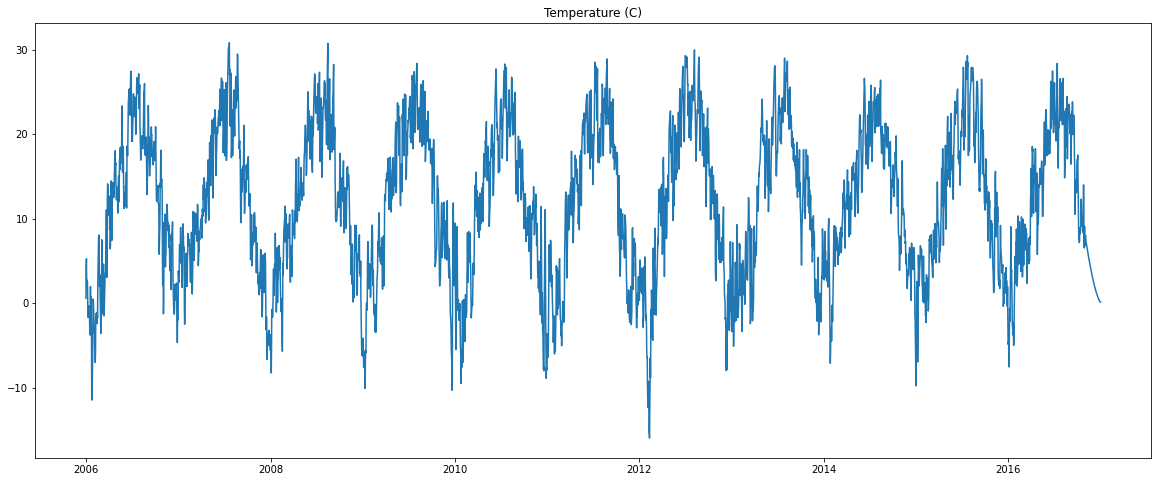

In [18]:
print (len(df_aggregate_temp))
plot_aggregates(df_aggregate_temp)

4019


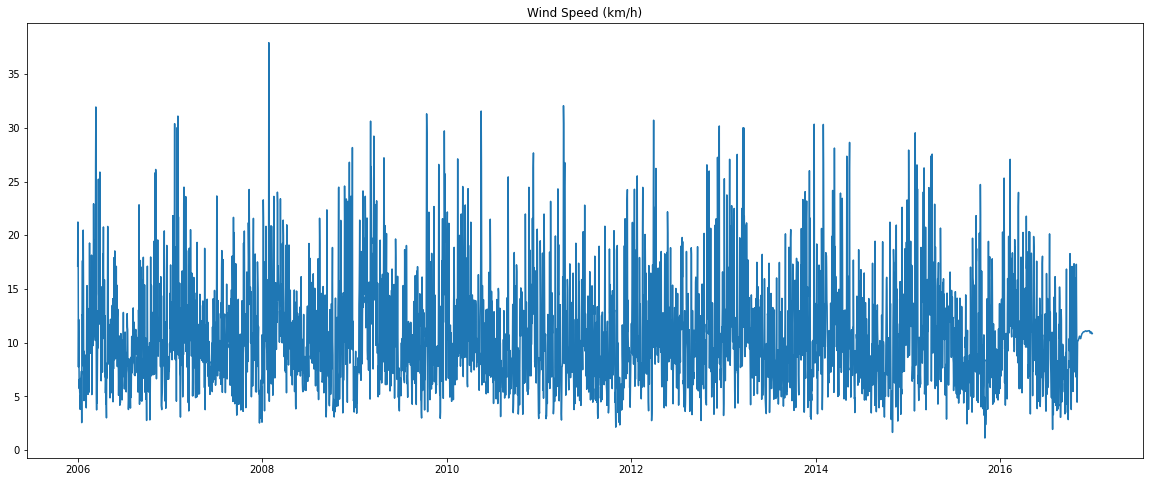

In [19]:
print (len(df_aggregate_ws))
plot_aggregates(df_aggregate_ws)

In [20]:
# Write a function to group data by formatted date column and count the number of entries for each date
def group_by_date(df, column_date, column):
    df_grouped = df.groupby([column_date]).count()
    return df_grouped

### Map streams to music parameters

#### Curently the whole song will  be mapped to just one scale across octaves 1-5. This is a simple approach. In future, can assign probabilities to switch keys based on some other parameter like windspeed.

#### Current mapping: 
##### - Temperature <-> Scale; 
##### - Wind speed <-> Velocity; 
##### - Humidity <-> Chord density

#### TODO: Chord selection - either the 135 of current note from the scale, or root, or fifth with a given probability

#### TODO: Key change probability <-> Humidity. or may be  low humidity = major. Phrygian for something that describes middle eastern  conditions.

In [136]:
scale_dict = {
    "M": np.array([0, 2, 4, 5, 7, 9, 11]),
    "m": np.array([0, 2, 3, 5, 7, 8, 10]),
    "d": np.array([0, 2, 3, 5, 7, 9, 10]),
    "mP": np.array([0, 3, 5, 7, 10]),
}

root_note_midi = {
    "C": 24,
    "C#": 25,
    "Db": 25,
    "D": 26,
    "D#": 27,
    "Eb": 27,
    "E": 28,
    "F": 29,
    "F#": 30,
    "Gb": 30,
    "G": 31,
    "G#": 32,
    "Ab": 32,
    "A": 33,
    "A#": 34,
    "Bb": 34,
    "B": 35,
}

def mapgen(root, scale, scale_dict, root_note_midi, highest_octave=7):
    """
    Generate all possible notes that temperature needs to be quantized to
    inputs: 
    root note
    scale type
    """
    if scale in scale_dict:
        scale = scale_dict[scale]
    else:
        raise ValueError("Invalid scale type")
    root_pitch = root_note_midi[root] + 12
    scale = root_pitch + scale

    pitches = scale
    for i in range(1, highest_octave):
        pitches = np.append(pitches, scale + 12*i)
    
    return pitches

def chordgen(root, notes_array, scale, scale_dict):
    if scale in scale_dict:
        scale = scale_dict[scale]
    else:
        raise ValueError("Invalid scale type")

    root_pitch = root_note_midi[root] + 12
    
    chords = []
    for note in notes_array:
        note_based = note % 12 + 36
        diff = np.where(scale == note_based-root_pitch)
        chord = []
        if len(diff[0]) > 0:
        # Get relation of note from root in terms of scale degree
            scale_degree = diff[0][0]
            n1 = note_based + 12
            chord.append(n1)
            n1n3Interval = scale[(scale_degree + 2) % 7] - scale[scale_degree]
            third = n1 + n1n3Interval
            chord.append(third)
            n1n5Interval = scale[(scale_degree + 4) % 7] - scale[scale_degree]
            fifth = n1 + n1n5Interval
            chord.append(fifth)
            chords.append(chord)
        else:
            chords.append(chord)
    return chords
        # third = (scale_degree + 2) % 7
    # return chords

In [137]:
# Write a function to scale df_aggregate_temp within minVal and maxVal
def scale_temperature(df, lowest_note, highest_note):
    minVal = df['Temperature (C)'].min()
    df['Scaled'] = df['Temperature (C)']
    df['Scaled'] = df['Scaled'].apply(lambda x: np.round(x - minVal + lowest_note, 0) )
    return df

def scale_windspeed(df, min, max):
    minVal = df['Wind Speed (km/h)'].min()

    # Get top 10 percentile value of wind speed
    maxValForced = df['Wind Speed (km/h)'].quantile(0.9)
    # Replace all values above 10 percentile with 10 percentile value
    df['Wind Speed (km/h)'] = df['Wind Speed (km/h)'].apply(lambda x: maxValForced if x > maxValForced else x)

    maxVal = df['Wind Speed (km/h)'].max()
    # scale between min and max
    df['WS_Scaled'] = df['Wind Speed (km/h)']
    df['WS_Scaled'] = df['WS_Scaled'].apply(lambda x: np.round((x - minVal) * (max - min) / (maxVal - minVal) + min, 0) )
    return df

In [138]:
def gen_chords_array(notes, df_aggregate_humidity):
    humidity = df_aggregate_humidity['Humidity'].values
    q1 = np.quantile(humidity, 0.25)
    q2 = np.quantile(humidity, 0.5)
    q3 = np.quantile(humidity, 0.75)
    
    chord_density = []
    for h in humidity:
        if h <= q1:
            chord_density.append(1)
        elif h <= q2:
            chord_density.append(2)
        elif h <= q3:
            chord_density.append(3)
        else:
            chord_density.append(4)

gen_chords_array('[]', df_aggregate_humidity)
    # return chords

In [150]:
root =  'C'
scale = 'm'
highest_octave = 7


pitches = mapgen(root, scale, scale_dict, root_note_midi, highest_octave)
lowest_note = pitches[0]
highest_note = pitches[-1]

In [151]:
df_midi = scale_temperature(df_aggregate_temp, lowest_note, highest_note)
notes_array = df_midi['Scaled'].values

In [152]:
scale_dict[scale]

array([ 0,  2,  3,  5,  7,  8, 10])

In [153]:
chordgen(root, notes_array, scale, scale_dict)

[[53.0, 56.0, 48.0],
 [56.0, 48.0, 51.0],
 [],
 [],
 [],
 [55.0, 58.0, 50.0],
 [55.0, 58.0, 50.0],
 [53.0, 56.0, 48.0],
 [51.0, 55.0, 58.0],
 [50.0, 53.0, 56.0],
 [51.0, 55.0, 58.0],
 [51.0, 55.0, 58.0],
 [],
 [],
 [51.0, 55.0, 58.0],
 [],
 [48.0, 51.0, 55.0],
 [48.0, 51.0, 55.0],
 [],
 [51.0, 55.0, 58.0],
 [50.0, 53.0, 56.0],
 [53.0, 56.0, 48.0],
 [],
 [],
 [53.0, 56.0, 48.0],
 [],
 [56.0, 48.0, 51.0],
 [],
 [48.0, 51.0, 55.0],
 [],
 [],
 [51.0, 55.0, 58.0],
 [50.0, 53.0, 56.0],
 [48.0, 51.0, 55.0],
 [],
 [48.0, 51.0, 55.0],
 [58.0, 50.0, 53.0],
 [],
 [58.0, 50.0, 53.0],
 [50.0, 53.0, 56.0],
 [51.0, 55.0, 58.0],
 [51.0, 55.0, 58.0],
 [51.0, 55.0, 58.0],
 [51.0, 55.0, 58.0],
 [50.0, 53.0, 56.0],
 [51.0, 55.0, 58.0],
 [50.0, 53.0, 56.0],
 [],
 [56.0, 48.0, 51.0],
 [58.0, 50.0, 53.0],
 [48.0, 51.0, 55.0],
 [48.0, 51.0, 55.0],
 [],
 [],
 [],
 [55.0, 58.0, 50.0],
 [],
 [53.0, 56.0, 48.0],
 [50.0, 53.0, 56.0],
 [48.0, 51.0, 55.0],
 [],
 [50.0, 53.0, 56.0],
 [51.0, 55.0, 58.0],
 [],
 [55.0, 

In [154]:
lowest_vel = 0
highest_vel = 127
df_vel = scale_windspeed(df_aggregate_ws, 0, 127)
velocities_array = df_vel['WS_Scaled'].values

In [155]:
chords_array = chordgen(root, notes_array, scale, scale_dict)

In [156]:
chords_array

[[53.0, 56.0, 48.0],
 [56.0, 48.0, 51.0],
 [],
 [],
 [],
 [55.0, 58.0, 50.0],
 [55.0, 58.0, 50.0],
 [53.0, 56.0, 48.0],
 [51.0, 55.0, 58.0],
 [50.0, 53.0, 56.0],
 [51.0, 55.0, 58.0],
 [51.0, 55.0, 58.0],
 [],
 [],
 [51.0, 55.0, 58.0],
 [],
 [48.0, 51.0, 55.0],
 [48.0, 51.0, 55.0],
 [],
 [51.0, 55.0, 58.0],
 [50.0, 53.0, 56.0],
 [53.0, 56.0, 48.0],
 [],
 [],
 [53.0, 56.0, 48.0],
 [],
 [56.0, 48.0, 51.0],
 [],
 [48.0, 51.0, 55.0],
 [],
 [],
 [51.0, 55.0, 58.0],
 [50.0, 53.0, 56.0],
 [48.0, 51.0, 55.0],
 [],
 [48.0, 51.0, 55.0],
 [58.0, 50.0, 53.0],
 [],
 [58.0, 50.0, 53.0],
 [50.0, 53.0, 56.0],
 [51.0, 55.0, 58.0],
 [51.0, 55.0, 58.0],
 [51.0, 55.0, 58.0],
 [51.0, 55.0, 58.0],
 [50.0, 53.0, 56.0],
 [51.0, 55.0, 58.0],
 [50.0, 53.0, 56.0],
 [],
 [56.0, 48.0, 51.0],
 [58.0, 50.0, 53.0],
 [48.0, 51.0, 55.0],
 [48.0, 51.0, 55.0],
 [],
 [],
 [],
 [55.0, 58.0, 50.0],
 [],
 [53.0, 56.0, 48.0],
 [50.0, 53.0, 56.0],
 [48.0, 51.0, 55.0],
 [],
 [50.0, 53.0, 56.0],
 [51.0, 55.0, 58.0],
 [],
 [55.0, 

In [157]:
song_duration = 1800 # duration in seconds
frame_rate = len(notes_array)/song_duration
note_duration = 1/frame_rate
print (note_duration)
whole_note_duration = 4*note_duration # in seconds

0.44787260512565313


In [158]:
# Write a function to send a midi note to Max/MSP patch using OSC
def send_midi_note(note, vel, dur, client):
    client.send_message("midiNum", note)
    client.send_message("vel", vel)
    client.send_message("dur", dur)

def send_chord_notes(notes, vel, client):
    client.send_message("chord", notes)
    client.send_message("vel", vel)

In [159]:
def stopSound(client):
    send_midi_note(0, 0, 1, client)

def play_midi(notes_array, chords_array, velocities_array, note_duration, client_melody, client_chords):
    for i, n in enumerate(notes_array):
        vel = velocities_array[i]
        send_chord_notes(chords_array[i], 127-vel, client_chords)
        if n in pitches:
            send_midi_note(n, vel, note_duration, client_melody)
            time.sleep(note_duration)
        else:
            time.sleep(note_duration)

    stopSound(client_melody)
    time.sleep(note_duration)


In [162]:
try:
    IP = "127.0.0.1"
    PORT_TO_MAX_MELODY = 1001
    PORT_TO_MAX_CHORDS = 1002
    client_melody = udp_client.SimpleUDPClient(IP, PORT_TO_MAX_MELODY)
    client_chords = udp_client.SimpleUDPClient(IP, PORT_TO_MAX_CHORDS)

    play_midi(notes_array, chords_array, velocities_array, note_duration, client_melody,  client_chords)
    stopSound(client_melody)
except KeyboardInterrupt:
    stopSound(client_melody)